In [7]:
import sqlite3
import pandas as pd
import datetime
import numpy as np
from matplotlib import pyplot as plt

database = "../main.db"

In [2]:
conn = sqlite3.connect(database)

In [3]:
pd.read_sql_query('SELECT * FROM earnings limit 10', conn)

,id,ticker,name,cap,eps_estimate,eps_reported,surprise,surprise_pct,revenue,revenue_fx,eps_date,period_ending,file_date
0,1,STZ,"CONSTELLATION BRANDS, INC.",4.695200e+10,2.09,2.37,-0.22,-10.39,2.103000e+09,2017000000,2022-04-07 00:00:00,2022-02-28 00:00:00,2022-04-10 00:00:00
1,2,CAG,"CONAGRA BRANDS, INC.",1.655000e+10,0.58,0.58,-0.13,-21.67,2.914000e+09,2846000000,2022-04-07 00:00:00,2022-02-28 00:00:00,2022-04-10 00:00:00
2,3,RPM,RPM INTERNATIONAL INC.,1.109900e+10,0.30,0.38,-0.05,-16.76,1.434000e+09,1400000000,2022-04-06 00:00:00,2022-02-28 00:00:00,2022-04-10 00:00:00
3,4,LW,"LAMB WESTON HOLDINGS, INC.",9.631000e+09,0.44,0.73,0.29,65.25,9.550000e+08,968517000,2022-04-07 00:00:00,2022-02-28 00:00:00,2022-04-10 00:00:00
4,5,LEVI,LEVI STRAUSS & CO,7.488000e+09,0.42,0.46,0.06,15.19,1.592000e+09,1547000000,2022-04-06 00:00:00,2022-02-28 00:00:00,2022-04-10 00:00:00
5,6,AYI,"ACUITY BRANDS, INC.",5.908000e+09,2.38,2.57,0.09,3.84,9.091000e+08,884617000,2022-04-05 00:00:00,2022-02-28 00:00:00,2022-04-10 00:00:00
6,7,TRNO,TERRENO REALTY CORPORATION,5.737000e+09,0.27,0.28,0.16,59.96,6.270000e+07,62811000,2022-04-07 00:00:00,2022-03-31 00:00:00,2022-04-10 00:00:00
7,8,ATC,ATOTECH LIMITED,4.256000e+09,0.20,0.15,-0.05,-25.22,3.865000e+08,377730000,2022-04-04 00:00:00,2021-12-31 00:00:00,2022-04-10 00:00:00
8,9,SMPL,THE SIMPLY GOOD FOODS COMPANY,4.015000e+09,0.28,0.36,-0.06,-21.60,2.967180e+08,274797000,2022-04-06 00:00:00,2022-02-28 00:00:00,2022-04-10 00:00:00
9,10,CXM,"SPRINKLR, INC.",3.523000e+09,-0.09,-0.05,-0.03,-33.77,1.356670e+08,130370000,2022-04-06 00:00:00,2022-01-31 00:00:00,2022-04-10 00:00:00


In [6]:
pd.read_sql_query('SELECT * FROM history limit 10', conn)

,id,ticker,trade_date,open,high,low,close,volume
0,1,LW,2022-01-03 00:00:00-05:00,63.410000,63.952999,63.020000,63.919998,1689100
1,2,LW,2022-01-04 00:00:00-05:00,63.919998,64.260002,63.160000,63.299999,2269100
2,3,LW,2022-01-05 00:00:00-05:00,63.369999,64.154999,62.520000,63.119999,1735700
3,4,LW,2022-01-06 00:00:00-05:00,69.099998,71.580002,67.019997,67.820000,5555900
4,5,LW,2022-01-07 00:00:00-05:00,67.800003,70.675003,67.250000,70.239998,3026100
5,6,LW,2022-01-10 00:00:00-05:00,70.239998,70.680000,67.699997,68.540001,2278600
6,7,LW,2022-01-11 00:00:00-05:00,68.449997,69.599998,68.449997,69.330002,1711600
7,8,LW,2022-01-12 00:00:00-05:00,69.570000,69.849998,68.740997,68.830002,1460100
8,9,LW,2022-01-13 00:00:00-05:00,68.910004,69.418999,68.720001,69.040001,1078400
9,10,LW,2022-01-14 00:00:00-05:00,68.400002,69.089996,68.110001,68.930000,1190000


## query 1

In [37]:
q = """
    with comp as (
        select 
        *,
        date(file_date, '+2 months') as deadline
        from earnings
        where surprise_pct > 0.0
        limit 2000
    ), combo as (
        select
            comp.ticker,
            comp.surprise_pct,
            date(comp.file_date) as start,
            comp.deadline,
            h.trade_date,
            h.close,
            row_number() over (partition by comp.ticker order by trade_date asc) as r
        from comp
        left join history h
        on h.ticker=comp.ticker

        where trade_date>start 
        and trade_date<deadline
    ), fv as (
        select
            ticker,
            close as start_close
        from combo
        where r=1
    ), preselect as (
        select 
            combo.ticker,
            trade_date,
            100-100.0*close/start_close as change_pct
        from combo
        left join fv
        on fv.ticker=combo.ticker
    )
    select
        ticker,
        min(change_pct) as min_pct,
        max(change_pct) as max_pct
    from preselect
    group by ticker
"""

out=pd.read_sql_query(q, conn)
out

,ticker,min_pct,max_pct
0,A,-9.650359,11.641579
1,AA,-21.623930,24.123934
2,AAL,-5.886524,11.489367
3,AAON,-3.457142,9.394677
4,AAPL,-10.502656,20.207650
...,...,...,...
1142,ZIP,-23.663185,5.654579
1143,ZM,-14.136810,32.722194
1144,ZS,-26.461566,24.064274
1145,ZTS,-10.685377,3.609169


In [38]:
out[['min_pct','max_pct']].agg(['min','max','mean','count'])

,min_pct,max_pct
min,-313.793095,0.000000
max,0.000000,76.638462
mean,-15.174275,16.578444
count,1147.000000,1147.000000


## query 2

In [223]:
q = """
    with comp as (
        select 
        *,
        date(file_date, '+2 months') as deadline
        from earnings
        where surprise_pct > 0.0
    ), combo as (
        select
            comp.*,
            date(comp.file_date) as start,
            h.trade_date,
            h.close,
            row_number() over (partition by comp.ticker,comp.file_date order by trade_date asc) as trade_day
        from comp
        left join history h
        on h.ticker=comp.ticker

        where trade_date>start 
        and trade_date<deadline
    ), start_prices as (
        select ticker, file_date, close from combo
        where trade_day=1
    )
    select
        combo.*,
        start_prices.close as start_close,
        1.0-combo.close/start_prices.close as close_pct
    from combo
    left join start_prices
      on start_prices.ticker=combo.ticker
      and start_prices.file_date=combo.file_date
"""

out=pd.read_sql_query(q, conn)
out

,id,ticker,name,cap,eps_estimate,eps_reported,surprise,surprise_pct,revenue,revenue_fx,eps_date,period_ending,file_date,deadline,start,trade_date,close,trade_day,start_close,close_pct
0,926,A,"AGILENT TECHNOLOGIES, INC.",3.918000e+10,1.12,1.13,0.01,0.94,NaN,1.616000e+09,None,None,2022-05-28 00:00:00,2022-07-28,2022-05-28,2022-05-31 00:00:00-04:00,127.559998,1,127.559998,0.000000
1,926,A,"AGILENT TECHNOLOGIES, INC.",3.918000e+10,1.12,1.13,0.01,0.94,NaN,1.616000e+09,None,None,2022-05-28 00:00:00,2022-07-28,2022-05-28,2022-06-01 00:00:00-04:00,123.089996,2,127.559998,0.035042
2,926,A,"AGILENT TECHNOLOGIES, INC.",3.918000e+10,1.12,1.13,0.01,0.94,NaN,1.616000e+09,None,None,2022-05-28 00:00:00,2022-07-28,2022-05-28,2022-06-02 00:00:00-04:00,129.100006,3,127.559998,-0.012073
3,926,A,"AGILENT TECHNOLOGIES, INC.",3.918000e+10,1.12,1.13,0.01,0.94,NaN,1.616000e+09,None,None,2022-05-28 00:00:00,2022-07-28,2022-05-28,2022-06-03 00:00:00-04:00,128.490005,4,127.559998,-0.007291
4,926,A,"AGILENT TECHNOLOGIES, INC.",3.918000e+10,1.12,1.13,0.01,0.94,NaN,1.616000e+09,None,None,2022-05-28 00:00:00,2022-07-28,2022-05-28,2022-06-06 00:00:00-04:00,127.629997,5,127.559998,-0.000549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77920,3706,ZUO,"ZUORA, INC.",7.836110e+08,-0.06,-0.02,0.04,66.67,NaN,1.000910e+08,None,None,2022-12-10 00:00:00,2023-02-10,2022-12-10,2023-01-09 00:00:00-05:00,6.520000,19,6.310000,-0.033281
77921,3706,ZUO,"ZUORA, INC.",7.836110e+08,-0.06,-0.02,0.04,66.67,NaN,1.000910e+08,None,None,2022-12-10 00:00:00,2023-02-10,2022-12-10,2023-01-10 00:00:00-05:00,6.580000,20,6.310000,-0.042789
77922,3706,ZUO,"ZUORA, INC.",7.836110e+08,-0.06,-0.02,0.04,66.67,NaN,1.000910e+08,None,None,2022-12-10 00:00:00,2023-02-10,2022-12-10,2023-01-11 00:00:00-05:00,6.710000,21,6.310000,-0.063391
77923,3706,ZUO,"ZUORA, INC.",7.836110e+08,-0.06,-0.02,0.04,66.67,NaN,1.000910e+08,None,None,2022-12-10 00:00:00,2023-02-10,2022-12-10,2023-01-12 00:00:00-05:00,6.710000,22,6.310000,-0.063391


In [265]:
conn.close()

## processing

In [224]:
out.drop(columns=['id','name','eps_date','period_ending','revenue'], inplace=True)

In [225]:
out.set_index(['ticker','start'],inplace=True)

In [226]:
out['trade_date'] = pd.to_datetime(out['trade_date'])
out['cap'] = out['cap'] / 1e9
out['revenue_fx'] = out['revenue_fx'] / 1e9

In [227]:
# sort index to avoid PerformanceWarning: indexing past lexsort depth may impact performance.
out.sort_index(inplace=True)

In [228]:
# sample multiindex usage
# out.loc[('ZUO','2022-08-28')]

In [229]:
# unique indices
ticker_start = out.index.unique().to_list()
print(len(ticker_start))

1932


In [230]:
def plot_anything(out: pd.DataFrame, ticker: str, start: str, col: str=None, x: str='trade_date', title: str='') -> None:
    """
        x: trade_date, trade_day
        plottable: close, close_pct
    """
    try:
        df = out.loc[(ticker,start)]
    except:
        print('not found but tuple in index?',(ticker,start) in out.index)
        return
    
    if col is not None:
        df.plot(x,col, title=title)
# plot_anything(out, *ticker_start[0], col='close_pct')

In [231]:
stationary = out[out.trade_day==1][['cap', 'eps_estimate', 'eps_reported', 'surprise', 'surprise_pct','revenue_fx', 'file_date', 'deadline']]
stationary.head(3)

cap  eps_estimate  eps_reported  surprise  surprise_pct  \
ticker start                                                                    
A      2022-05-28  39.180          1.12          1.13      0.01          0.94   
       2022-08-21  41.108          1.20          1.34      0.14         11.57   
AA     2022-07-24   8.448          2.31          2.67      0.36         15.38   

                   revenue_fx            file_date    deadline  
ticker start                                                    
A      2022-05-28       1.616  2022-05-28 00:00:00  2022-07-28  
       2022-08-21       1.637  2022-08-21 00:00:00  2022-10-21  
AA     2022-07-24       3.453  2022-07-24 00:00:00  2022-09-24

## show random

Selected MOMO 2022-09-03
cap                           1.056
eps_estimate                   0.24
eps_reported                   0.25
surprise                       0.01
surprise_pct                   4.48
revenue_fx                 0.457283
file_date       2022-09-03 00:00:00
deadline                 2022-11-03
Name: (MOMO, 2022-09-03), dtype: object


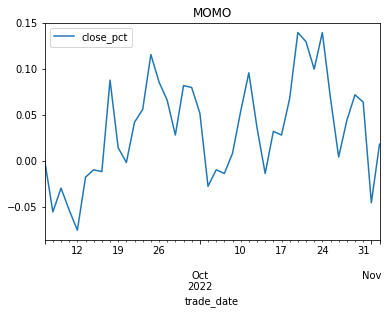

In [233]:
import random
ticker, start = random.choice(ticker_start)
print("Selected",ticker, start)
print(stationary.loc[ticker, start])
plot_anything(out, ticker, start, col='close_pct', title=ticker)

## feature extraction

In [253]:
GAIN_THRESHOLD = 0.1 # min value of the max gain

In [301]:
F = stationary.copy().drop(columns=['file_date','deadline','revenue_fx'])
for ticker, start in ticker_start:
    sub = out.loc[ticker, start].copy()
    init_close = sub.head(1)['close'].values[0]
    F.loc[(ticker, start),'init_close'] = init_close

    # calc target variable(s)
    max_close_pct = sub.max()['close_pct']
    max_close_pct > GAIN_THRESHOLD
    F.loc[(ticker, start),'tgt_isabovethreshold'] = int(max_close_pct >= GAIN_THRESHOLD) 

In [302]:
F.mean()

cap                      38.680523
eps_estimate              1.303602
eps_reported              1.534218
surprise                  0.264928
surprise_pct            232.232412
init_close              106.943612
tgt_isabovethreshold      0.511387
dtype: float64

## simple tree

In [453]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [309]:
_=F.dropna(inplace=True)

In [377]:
X = F.drop(columns=['tgt_isabovethreshold']).to_numpy()
y = F['tgt_isabovethreshold'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)#, shuffle=True)

In [472]:
# clf = DecisionTreeClassifier()
# clf = RandomForestClassifier( # p=66% -> 75% @0.8
#     n_estimators=50,
#     max_depth=2,
# )
# clf = GradientBoostingClassifier( # p=63% -> %80 @0.7
#     learning_rate = 0.05, 
#     n_estimators = 30, 
#     subsample = .8,
#     random_state=7
# )
clf = AdaBoostClassifier( # p=67% => 68% @0.63
    learning_rate = 0.05, 
    n_estimators = 20, 
    random_state=7
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)
y_pred = (y_pred_proba[:,1]>0.63).astype(int) # we can reach 75% precision while still having ~55 predictions (per year) : RF with n=50, and cutoff=0.8

cm = confusion_matrix(y_test, y_pred)

res = {}
res['TN'] = cm[0][0]
res['FN'] = cm[1][0]
res['TP'] = cm[1][1]
res['FP'] = cm[0][1]
res['total_pos'] = res['TP']+res['FP']
res['precision'] = res['TP']/res['total_pos']
print(cm)

print(res)


[[273  39]
 [241  84]]
{'TN': 273, 'FN': 241, 'TP': 84, 'FP': 39, 'total_pos': 123, 'precision': 0.6829268292682927}
